Epoch [1/601], Loss: 64.2234
Epoch [11/601], Loss: 2.5192
Epoch [21/601], Loss: 5.4272
Epoch [31/601], Loss: 2.2846
Epoch 00041: reducing learning rate of group 0 to 5.0000e-03.
Epoch [41/601], Loss: 2.5539
Epoch [51/601], Loss: 2.0714
Epoch [61/601], Loss: 1.9325
Epoch [71/601], Loss: 1.8790
Epoch [81/601], Loss: 1.8598
Epoch [91/601], Loss: 1.8500
Epoch [101/601], Loss: 1.8381
Epoch [111/601], Loss: 1.8246
Epoch [121/601], Loss: 1.8114
Epoch [131/601], Loss: 1.7978
Epoch [141/601], Loss: 1.7836
Epoch [151/601], Loss: 1.7688
Epoch [161/601], Loss: 1.7535
Epoch [171/601], Loss: 1.7375
Epoch [181/601], Loss: 1.7210
Epoch [191/601], Loss: 1.7038
Epoch [201/601], Loss: 1.6860
Epoch [211/601], Loss: 1.6675
Epoch [221/601], Loss: 1.6483
Epoch [231/601], Loss: 1.6284
Epoch [241/601], Loss: 1.6077
Epoch [251/601], Loss: 1.5861
Epoch [261/601], Loss: 1.5637
Epoch [271/601], Loss: 1.5403
Epoch [281/601], Loss: 1.5159
Epoch [291/601], Loss: 1.4904
Epoch [301/601], Loss: 1.4637
Epoch [311/601], L

<Figure size 4000x600 with 0 Axes>

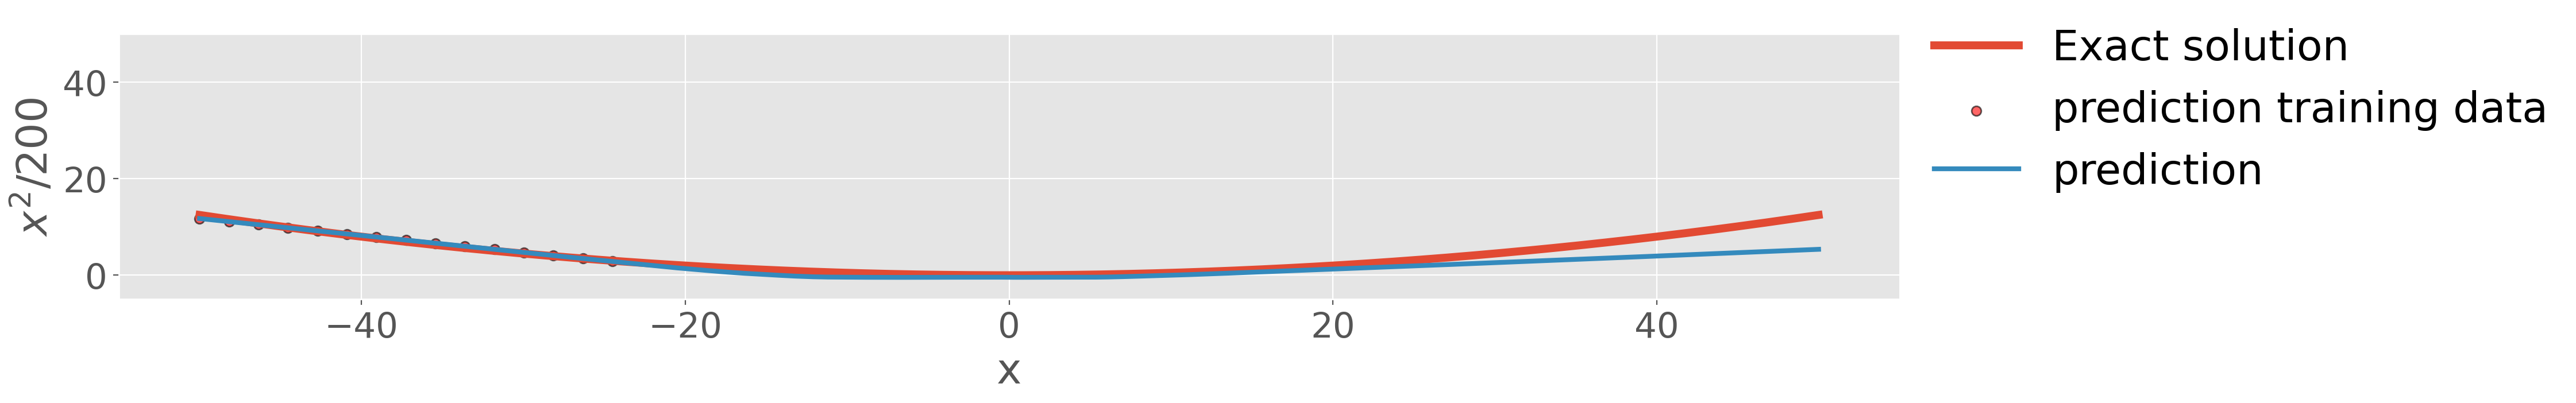

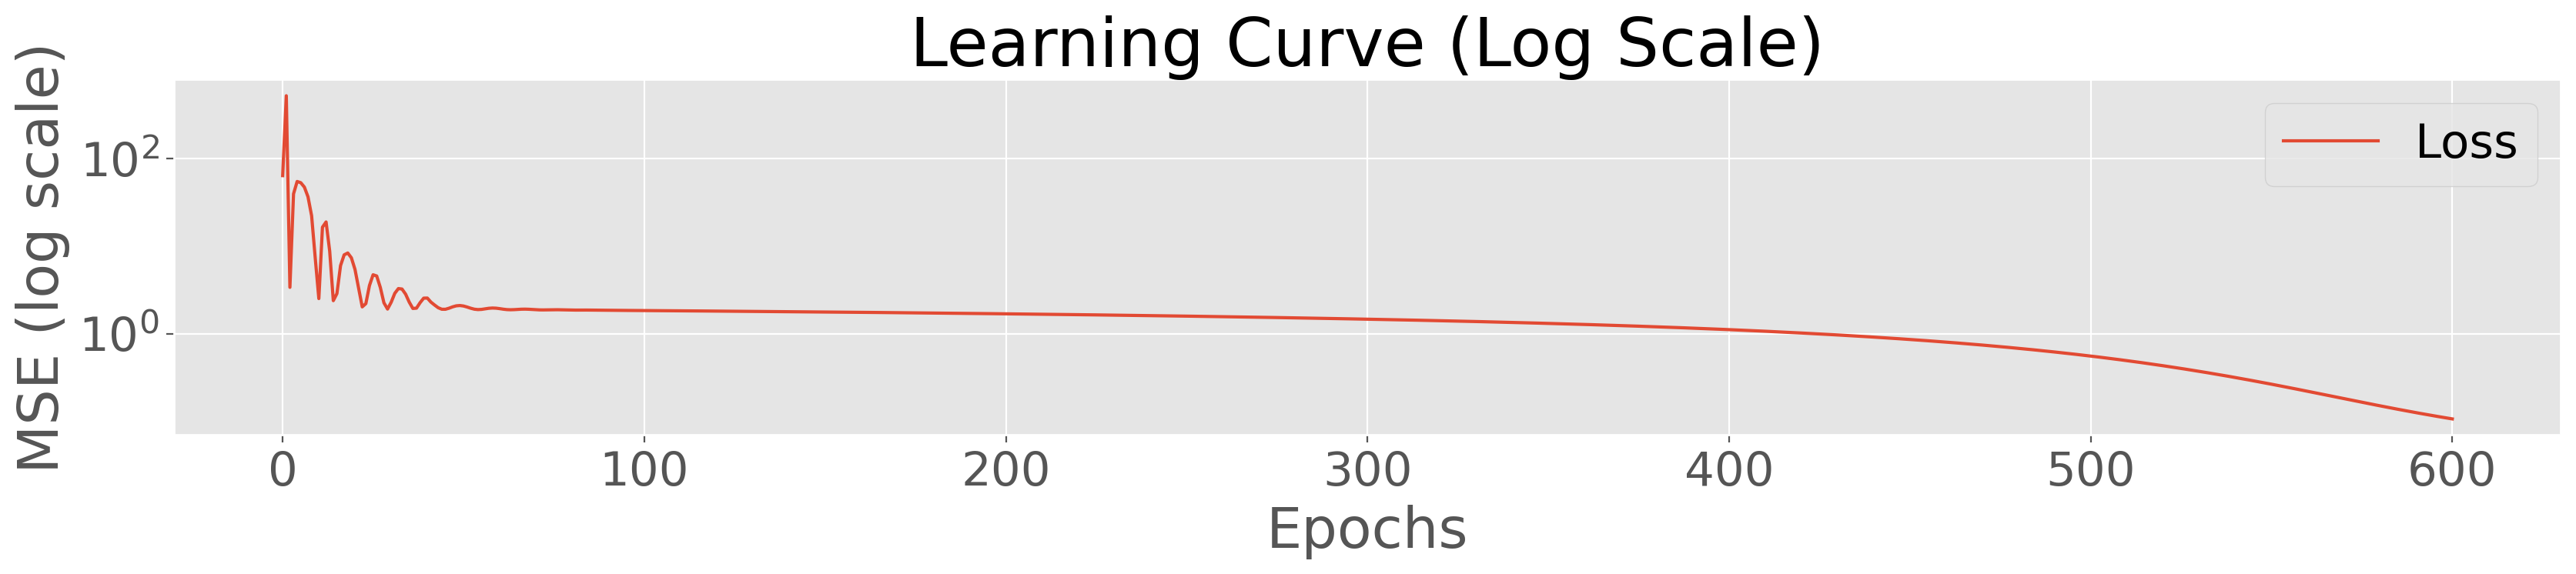

In [2]:
import random
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
import numpy as np
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import the LR scheduler
plt.style.use('ggplot')
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200  # high-res display
plt.rcParams["figure.figsize"] = (20, 3)
plt.rcParams.update({'font.size': 22})

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# If using CUDA (GPU), set the random seed for CUDA as well for reproducibility
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Data Generation
ndata = 550
x = np.linspace(-50, 50, ndata)
y = x ** 2 / 200

# Define the sliced data
x_data = x[0:150:10]
y_data = y[0:150:10]

# Convert data to PyTorch tensors
x_data = torch.tensor(x_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)



# Model definition
class Model2d(torch.nn.Module):
    def __init__(self):
        super(Model2d, self).__init__()
        self.layer1 = torch.nn.Linear(1, 132)
        self.layer2 = torch.nn.Linear(132, 132)
        self.layer3 = torch.nn.Linear(132, 132)
        self.layer4 = torch.nn.Linear(132, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.layer4(x)
        return x

model2d = Model2d()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model2d.parameters(), lr=1e-2)

# Initialize the LR scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Training loop
# Define batch size
batch_size = 32 
my_images = []
losses = []  # to store losses at each epoch

# Number of batches
num_batches = (len(x_data) + batch_size - 1) // batch_size  # Calculate num_batches

for epoch in range(601):  # Include epoch 600
    model2d.train()
    epoch_loss = 0.0
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(x_data))  # Handle the last batch which may be smaller
        batch_x = x_data[start_idx:end_idx].unsqueeze(1)
        batch_y = y_data[start_idx:end_idx].unsqueeze(1)

        optimizer.zero_grad()
        outputs = model2d(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss / num_batches)

    # Update the learning rate using the scheduler
    lr_scheduler.step(epoch_loss)

    # Performance plot
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/601], Loss: {epoch_loss / num_batches:.4f}')
        plt.figure()
        #plt.scatter(x, model2d(torch.tensor(x, dtype=torch.float32).unsqueeze(1)).detach().numpy(), alpha=0.6,
                    #color='#FF0000', lw=1, ec='black')
        #plt.scatter(x_data, y_data, alpha=0.1, color='blue', lw=1, ec='black')
        #plt.plot(x, x ** 2 / 200, lw=1, color='#0000FF')
        plt.ticklabel_format(useOffset=False, style='plain')
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlim([-50, 50])
        plt.ylim([-5, 20])
        plt.xlabel('x')
        plt.ylabel('$x^2/200$')
        plt.tight_layout()
        plt.title(f'Prediction Visualization - Epoch: {epoch}', fontsize=18)
        plt.close()
        fig = plt.gcf()
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        my_images.append(image)

# Save images as a GIF
imageio.mimsave('./model_2bpytorch.gif', my_images, fps=10)

plt.figure()
plt.plot(x, x ** 2 / 200, lw=5, label="Exact solution")
plt.scatter(x_data, model2d(x_data.unsqueeze(1)).detach().cpu().numpy(), alpha=0.6, color='#FF0000', lw=1, ec='black', label="prediction training data")
plt.plot(x, model2d(torch.tensor(x, dtype=torch.float32).unsqueeze(1)).detach().numpy(), lw=3, label="prediction")
plt.ylim([-5, 50])
plt.xlabel('x')
plt.ylabel('$x^2/200$')
l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
plt.setp(l.get_texts(), color="k")
plt.show()

# Plot the learning curve (MSE vs. Epochs) in log scale
plt.figure()
plt.semilogy(range(601), losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE (log scale)')
plt.title('Learning Curve (Log Scale)')
plt.legend()
plt.show()
